Notebook for K Neighbour Regression model

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

# create a default KNR pipelinei with standardised scaling
default_knr = Pipeline([
    ('scaler', StandardScaler()),
    ('knr', KNeighborsRegressor())
])

10-fold cross-validation used on full dataset to evaluate mean train and test metrics

In [47]:
from sklearn.model_selection import KFold, cross_validate
import numpy as np
%store -r X y

scoring = {
    "neg_mse": "neg_mean_squared_error",
    "neg_mae": "neg_mean_absolute_error",
    "r2": "r2"
}

# 10 fold cross validation setup 
ten_fold_cv = KFold(n_splits=10, shuffle=True, random_state=42)

# cross validate using default knr
default_cv = cross_validate(
    default_knr, 
    X, y,
    cv=ten_fold_cv,
    scoring=scoring,
    return_train_score=True
)

# check available keys
print(default_cv.keys())


# convert corrospinding negative errors to positive
train_mse = -default_cv["train_neg_mse"]
train_rmse = np.sqrt(train_mse).mean()              # get mean rmse over 10 folds

test_mse  = -default_cv["test_neg_mse"]
test_rmse = np.sqrt(test_mse).mean()

train_mae = -default_cv["train_neg_mae"].mean()
test_mae  = -default_cv["test_neg_mae"].mean()

# print default knr results
print("\nDefault KNR mean train RMSE:", train_rmse)
print("Default KNR mean test  RMSE:", test_rmse)

print("\nDefault KNR mean train MAE:", train_mae)
print("Default KNR mean test  MAE:", test_mae)

print("\nDefault KNR mean train R2:", default_cv["train_r2"].mean())
print("Default KNR mean test  R2:", default_cv["test_r2"].mean())
                                    

dict_keys(['fit_time', 'score_time', 'test_neg_mse', 'train_neg_mse', 'test_neg_mae', 'train_neg_mae', 'test_r2', 'train_r2'])

Default KNR mean train RMSE: 34.3076604870604
Default KNR mean test  RMSE: 42.65590640074778

Default KNR mean train MAE: 26.19680793929502
Default KNR mean test  MAE: 33.01488942465785

Default KNR mean train R2: 0.857842272435416
Default KNR mean test  R2: 0.7658132198063687


Find optimal hyperparameters for 'n_neighbors' and 'weights' using GridSearchCV

In [48]:
from sklearn.model_selection import GridSearchCV

# hp tuning using GridSearchCV
grid_knr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('tuned_knr', KNeighborsRegressor())
])

# enter range of hyperparameters to test (prefix hp's with model name in pipeline)
param_grid = {
    'tuned_knr__n_neighbors': [1, 2, 3, 4, 5, 10, 15, 20, 30, 50, 60, 70], 
    'tuned_knr__weights': ['uniform', 'distance']
}

# split the dataset and perform grid search with 10 fold cv
gridsearch_knr = GridSearchCV(grid_knr_pipeline, param_grid, cv= 10, scoring='neg_mean_squared_error')
gridsearch_knr.fit(X, y)

best_params = gridsearch_knr.best_params_
print(f"Best hyperparameters: {best_params}")


Best hyperparameters: {'tuned_knr__n_neighbors': 5, 'tuned_knr__weights': 'distance'}


Apply improved hyperparameters to new model

In [49]:

improved_knr = Pipeline([
    ('scaler', StandardScaler()),
    ('improved_knr', KNeighborsRegressor(n_neighbors=5, weights='distance'))
])


# cross validate using optimal knr
improved_cv = cross_validate(
    improved_knr, 
    X, y, 
    cv=ten_fold_cv,
    scoring=scoring,
    return_train_score=True
)


# convert corrospinding negative errors to positive
improved_train_mse = -improved_cv["train_neg_mse"]
improved_train_rmse = np.sqrt(improved_train_mse).mean()              # get mean rmse over 10 folds

improved_test_mse  = -improved_cv["test_neg_mse"]
improved_test_rmse = np.sqrt(improved_test_mse).mean()

improved_train_mae = -improved_cv["train_neg_mae"]
improved_test_mae  = -improved_cv["test_neg_mae"]

# print default knr results
#print("Improved KNR mean train RMSE:", improved_train_rmse)
print("Improved KNR mean test  RMSE:", improved_test_rmse)

#print("\nImproved KNR mean train MAE:", improved_train_mae.mean())
print("Improved KNR mean test  MAE:", improved_test_mae.mean())

print("Improved KNR mean test  R2:", improved_cv["test_r2"].mean())
                                    

Improved KNR mean test  RMSE: 39.660960336794496
Improved KNR mean test  MAE: 30.185019775135448
Improved KNR mean test  R2: 0.7975646646490675


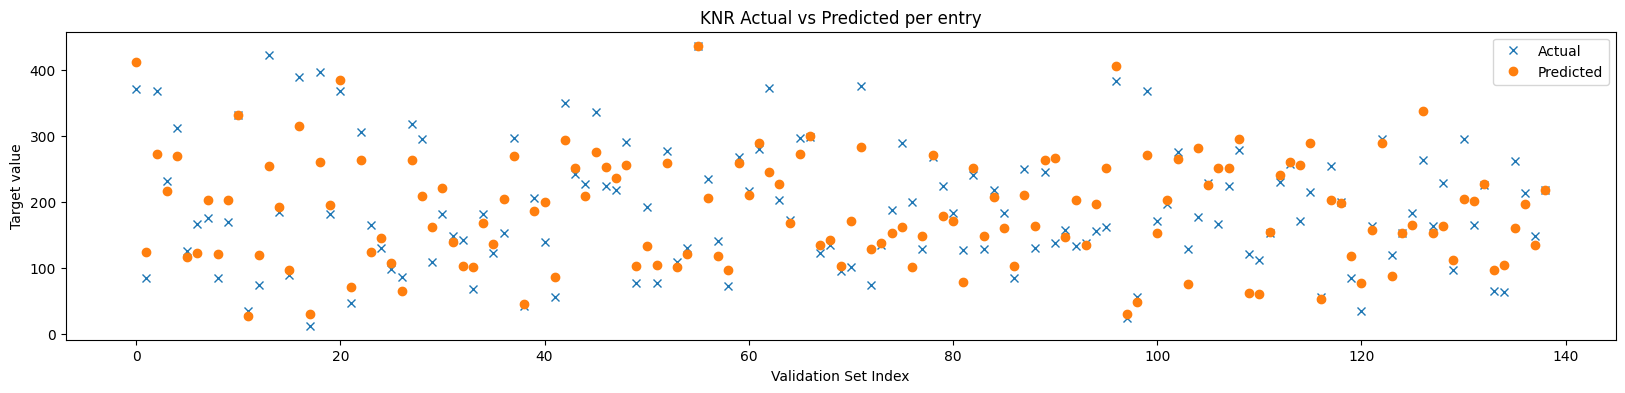

In [50]:
# create scatter plot to compare predictions to actual tensile stength over a given run (optimal hp's)
from sklearn.model_selection import train_test_split
import numpy as np, matplotlib.pyplot as plt

# new instance of knr
graph_knr = KNeighborsRegressor(n_neighbors=5, weights='distance')

# split the dataset into a training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

graph_knr.fit(X_train, y_train)

y_val_prediction = graph_knr.predict(X_val)     # predict values for validation set given training set

# store each prediction data entry in index for visualisation
index = np.arange(len(y_val))

plt.figure(figsize=(20, 4))
# plot acc vs pred
plt.plot(index, y_val, 'x', label='Actual')
plt.plot(index, y_val_prediction, 'o', label='Predicted')
plt.xlabel("Validation Set Index")
plt.ylabel("Target value")
plt.title("KNR Actual vs Predicted per entry")
plt.legend()
plt.show()

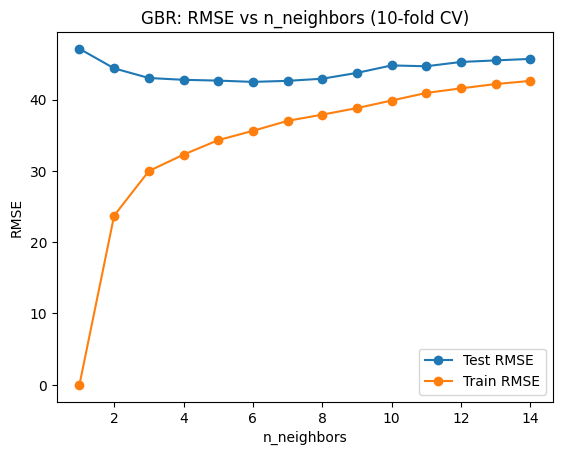

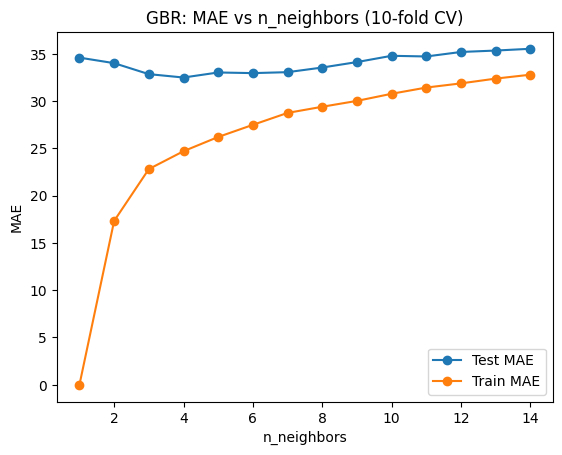

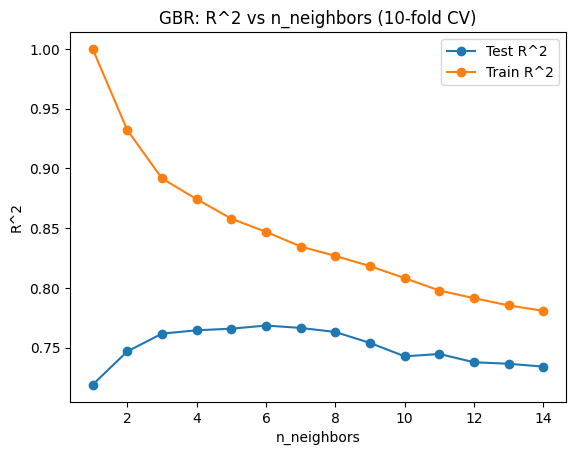

In [ ]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

# get n_neighbors across range of values
neighbor_count  = "tuned_knr__n_neighbors"
param_range = range(1, 15)


# root mean squared error (using negative mse) - validation curve
train_mse, test_mse = validation_curve(
    grid_knr_pipeline, 
    X, y,
    param_name=neighbor_count, 
    param_range=param_range,
    scoring="neg_mean_squared_error", 
    cv=ten_fold_cv
)
# convert to rmse
train_rmse = np.sqrt(-train_mse)
test_rmse  = np.sqrt(-test_mse)

# plot figures
plt.figure()
plt.plot(param_range, test_rmse.mean(axis=1), marker="o", label="Test RMSE")        # plot mean rmse across folds (test)
plt.plot(param_range, train_rmse.mean(axis=1), marker="o", label="Train RMSE")      # plot mean rmse across folds (train)
plt.xlabel("n_neighbors"); 
plt.ylabel("RMSE")
plt.title("GBR: RMSE vs n_neighbors (10-fold CV)")
plt.legend(); 
plt.show()

# mean absolute error
train_mae_g, test_mae_g = validation_curve(
    grid_knr_pipeline, 
    X, y,
    param_name=neighbor_count, 
    param_range=param_range,
    scoring="neg_mean_absolute_error", 
    cv=ten_fold_cv
)
# convert values to postive
train_mae = -train_mae_g
test_mae  = -test_mae_g

# plot results
plt.figure()
plt.plot(param_range, test_mae.mean(axis=1), marker="o", label="Test MAE")
plt.plot(param_range, train_mae.mean(axis=1), marker="o", label="Train MAE")
plt.xlabel("n_neighbors"); 
plt.ylabel("MAE")
plt.title("GBR: MAE vs n_neighbors (10-fold CV)")
plt.legend(); 
plt.show()

# sum of squared errors
train_r2, test_r2 = validation_curve(
    grid_knr_pipeline, 
    X, y,
    param_name=neighbor_count, 
    param_range=param_range,
    scoring="r2", 
    cv=ten_fold_cv
)

# plot r^2 metrics
plt.figure()
plt.plot(param_range, test_r2.mean(axis=1), marker="o", label="Test R^2")
plt.plot(param_range, train_r2.mean(axis=1), marker="o", label="Train R^2")
plt.xlabel("n_neighbors"); 
plt.ylabel("R^2")
plt.title("GBR: R^2 vs n_neighbors (10-fold CV)")
plt.legend(); 
plt.show()

